<h1>NYC CitiBike Network Assignment</h1>
<li>The file, citibike-tripdata.csv, contains citibike trip data from October 2024
<li>The file contains trip data with the following columns:
<br><br>   
    
    ride_id: Unique identifier for each trip
    rideable_type: Type of bike used
    started_at: Trip start timestamp
    ended_at: Trip end timestamp
    start_station_name, start_station_id: Starting station information
    end_station_name, end_station_id: Ending station information
    start_lat, start_lng: Starting coordinates
    end_lat, end_lng: Ending coordinates
    member_casual: Rider type (member/casual)
<br>
<li>Each record in the data is a trip
<li>The data is described at <a href="https://ride.citibikenyc.com/system-data">Citi Bike System Data</a>

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

<h1>STEP 1: Read the data into a dataframe</h1>

In [3]:
filename = "citibike-tripdata.csv"
df = pd.read_csv(filename)
df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,616E7E74038DCBF9,electric_bike,2024-10-17 17:40:45.993,2024-10-17 18:03:56.498,Goulden Ave & Bedford Park Blvd,8738.01,W 181 St & Riverside Dr,8381.04,40.873870,-73.895330,40.851680,-73.941860,member
1,4993E8CCD15147E4,classic_bike,2024-10-25 23:59:51.593,2024-10-26 00:09:09.720,98 St & 41 Ave,6304.04,104 St & Northern Blvd,6651.01,40.747730,-73.866490,40.757550,-73.864540,casual
2,28586C4580BCDDD5,electric_bike,2024-10-16 14:34:36.684,2024-10-16 14:46:27.222,Fulton St & Clermont Ave,4386.05,Court St & Nelson St,4077.07,40.684157,-73.969223,40.676395,-73.998699,casual
3,46164B02B3A1A388,electric_bike,2024-10-29 13:06:42.323,2024-10-29 13:23:15.483,Hazen St & 20 Ave,7032.06,31 St & Newtown Ave,6923.20,40.772092,-73.895166,40.767549,-73.920933,member
4,E6CA42DA26C40CA4,electric_bike,2024-10-28 06:58:45.631,2024-10-28 07:10:27.007,Dean St & Hoyt St,4446.05,Murray St & West St,5329.08,40.686444,-73.987591,40.715030,-74.012460,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...
150049,A276B1C529706655,electric_bike,2024-10-19 12:28:42.064,2024-10-19 12:45:39.540,Wards Meadow Comfort Station,7327.01,E 84 St & 1 Ave,7180.02,40.782940,-73.930770,40.775655,-73.950686,casual
150050,F4C5052612B94069,electric_bike,2024-10-30 14:05:06.685,2024-10-30 14:35:19.775,Clarkson Ave & Utica Ave,3486.02,Lafayette Ave & Ft Greene Pl,4470.09,40.656660,-73.931090,40.687002,-73.976650,member
150051,8A22E0971A5D64D4,electric_bike,2024-10-30 10:54:53.674,2024-10-30 11:04:11.948,Hudson St & W 13 St,6115.06,Broadway & W 36 St,6441.01,40.740057,-74.005274,40.750977,-73.987654,member
150052,914B8A35B6EB7D76,classic_bike,2024-10-26 22:25:21.426,2024-10-26 22:31:00.367,Grand St & Elizabeth St,5382.06,Lafayette St & Jersey St,5561.06,40.718822,-73.995960,40.724561,-73.995653,member


<h1>STEP 2: Data cleaning and Preprocessing</h1>

<li>Remove data that have any nans in any row</li>
<li>Convert start_station_name, end_station_name to str</li>
<li>Convert started_at, ended_at to datetime</li>
<li>Convert start_station_id, end_station_id to str</li>

In [4]:
df = df.dropna()
df['start_station_name'] = df['start_station_name'].astype(str)
df['end_station_name'] = df['end_station_name'].astype(str)
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])
df['start_station_id'] = df['start_station_id'].astype(str)
df['end_station_id'] = df['end_station_id'].astype(str)

<h1>STEP 3: Feature engineering

<br>Now on the data, create the following features:
<li>Calculate trip duration in minutes(rounded off to two decimal digits) by performing some actions on the two timestamps. Store this in a new column called "duration"
<li>Calculate trip distance in kilometers using the following formula (approx): $$ Distance = 111 \times \sqrt{(lat_{end} - lat_{start})^2 + (lng_{end} - lng_{start})^2} $$
<br> Runde it off to two decimal digits and store this in a new column called "distance"


$$ Distance = 111 \times \sqrt{(lat_{end} - lat_{start})^2 + (lng_{end} - lng_{start})^2} $$

In [5]:
df['duration'] = ((df['ended_at'] - df['started_at']).dt.total_seconds())/60
df['duration'] = df['duration'].round(2)
df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration
0,616E7E74038DCBF9,electric_bike,2024-10-17 17:40:45.993,2024-10-17 18:03:56.498,Goulden Ave & Bedford Park Blvd,8738.01,W 181 St & Riverside Dr,8381.04,40.873870,-73.895330,40.851680,-73.941860,member,23.18
1,4993E8CCD15147E4,classic_bike,2024-10-25 23:59:51.593,2024-10-26 00:09:09.720,98 St & 41 Ave,6304.04,104 St & Northern Blvd,6651.01,40.747730,-73.866490,40.757550,-73.864540,casual,9.30
2,28586C4580BCDDD5,electric_bike,2024-10-16 14:34:36.684,2024-10-16 14:46:27.222,Fulton St & Clermont Ave,4386.05,Court St & Nelson St,4077.07,40.684157,-73.969223,40.676395,-73.998699,casual,11.84
3,46164B02B3A1A388,electric_bike,2024-10-29 13:06:42.323,2024-10-29 13:23:15.483,Hazen St & 20 Ave,7032.06,31 St & Newtown Ave,6923.20,40.772092,-73.895166,40.767549,-73.920933,member,16.55
4,E6CA42DA26C40CA4,electric_bike,2024-10-28 06:58:45.631,2024-10-28 07:10:27.007,Dean St & Hoyt St,4446.05,Murray St & West St,5329.08,40.686444,-73.987591,40.715030,-74.012460,member,11.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150049,A276B1C529706655,electric_bike,2024-10-19 12:28:42.064,2024-10-19 12:45:39.540,Wards Meadow Comfort Station,7327.01,E 84 St & 1 Ave,7180.02,40.782940,-73.930770,40.775655,-73.950686,casual,16.96
150050,F4C5052612B94069,electric_bike,2024-10-30 14:05:06.685,2024-10-30 14:35:19.775,Clarkson Ave & Utica Ave,3486.02,Lafayette Ave & Ft Greene Pl,4470.09,40.656660,-73.931090,40.687002,-73.976650,member,30.22
150051,8A22E0971A5D64D4,electric_bike,2024-10-30 10:54:53.674,2024-10-30 11:04:11.948,Hudson St & W 13 St,6115.06,Broadway & W 36 St,6441.01,40.740057,-74.005274,40.750977,-73.987654,member,9.30
150052,914B8A35B6EB7D76,classic_bike,2024-10-26 22:25:21.426,2024-10-26 22:31:00.367,Grand St & Elizabeth St,5382.06,Lafayette St & Jersey St,5561.06,40.718822,-73.995960,40.724561,-73.995653,member,5.65


In [6]:
df['distance'] = 111 * np.sqrt((df['end_lat']-df['start_lat'])**2 + (df['end_lng']-df['start_lng'])**2)
df['distance'] = df['distance'].round(2)
df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration,distance
0,616E7E74038DCBF9,electric_bike,2024-10-17 17:40:45.993,2024-10-17 18:03:56.498,Goulden Ave & Bedford Park Blvd,8738.01,W 181 St & Riverside Dr,8381.04,40.873870,-73.895330,40.851680,-73.941860,member,23.18,5.72
1,4993E8CCD15147E4,classic_bike,2024-10-25 23:59:51.593,2024-10-26 00:09:09.720,98 St & 41 Ave,6304.04,104 St & Northern Blvd,6651.01,40.747730,-73.866490,40.757550,-73.864540,casual,9.30,1.11
2,28586C4580BCDDD5,electric_bike,2024-10-16 14:34:36.684,2024-10-16 14:46:27.222,Fulton St & Clermont Ave,4386.05,Court St & Nelson St,4077.07,40.684157,-73.969223,40.676395,-73.998699,casual,11.84,3.38
3,46164B02B3A1A388,electric_bike,2024-10-29 13:06:42.323,2024-10-29 13:23:15.483,Hazen St & 20 Ave,7032.06,31 St & Newtown Ave,6923.20,40.772092,-73.895166,40.767549,-73.920933,member,16.55,2.90
4,E6CA42DA26C40CA4,electric_bike,2024-10-28 06:58:45.631,2024-10-28 07:10:27.007,Dean St & Hoyt St,4446.05,Murray St & West St,5329.08,40.686444,-73.987591,40.715030,-74.012460,member,11.69,4.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150049,A276B1C529706655,electric_bike,2024-10-19 12:28:42.064,2024-10-19 12:45:39.540,Wards Meadow Comfort Station,7327.01,E 84 St & 1 Ave,7180.02,40.782940,-73.930770,40.775655,-73.950686,casual,16.96,2.35
150050,F4C5052612B94069,electric_bike,2024-10-30 14:05:06.685,2024-10-30 14:35:19.775,Clarkson Ave & Utica Ave,3486.02,Lafayette Ave & Ft Greene Pl,4470.09,40.656660,-73.931090,40.687002,-73.976650,member,30.22,6.08
150051,8A22E0971A5D64D4,electric_bike,2024-10-30 10:54:53.674,2024-10-30 11:04:11.948,Hudson St & W 13 St,6115.06,Broadway & W 36 St,6441.01,40.740057,-74.005274,40.750977,-73.987654,member,9.30,2.30
150052,914B8A35B6EB7D76,classic_bike,2024-10-26 22:25:21.426,2024-10-26 22:31:00.367,Grand St & Elizabeth St,5382.06,Lafayette St & Jersey St,5561.06,40.718822,-73.995960,40.724561,-73.995653,member,5.65,0.64


<h1>STEP 4: Data filtering</h1>

<br>On the data that we now have, filter the data as follows:
<li> Trip duration has to be 1 minute or more
<li> Trip duration has to be less than 24 hours (or 1440 minutes)
<li> Trip start and end station must be different
<li> Be careful of columns duplication

In [7]:
df = df[ (df['duration'] >= 1) & (df['duration'] <= 1440) & (df['start_station_name'] != df['end_station_name'])]
df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration,distance
0,616E7E74038DCBF9,electric_bike,2024-10-17 17:40:45.993,2024-10-17 18:03:56.498,Goulden Ave & Bedford Park Blvd,8738.01,W 181 St & Riverside Dr,8381.04,40.873870,-73.895330,40.851680,-73.941860,member,23.18,5.72
1,4993E8CCD15147E4,classic_bike,2024-10-25 23:59:51.593,2024-10-26 00:09:09.720,98 St & 41 Ave,6304.04,104 St & Northern Blvd,6651.01,40.747730,-73.866490,40.757550,-73.864540,casual,9.30,1.11
2,28586C4580BCDDD5,electric_bike,2024-10-16 14:34:36.684,2024-10-16 14:46:27.222,Fulton St & Clermont Ave,4386.05,Court St & Nelson St,4077.07,40.684157,-73.969223,40.676395,-73.998699,casual,11.84,3.38
3,46164B02B3A1A388,electric_bike,2024-10-29 13:06:42.323,2024-10-29 13:23:15.483,Hazen St & 20 Ave,7032.06,31 St & Newtown Ave,6923.20,40.772092,-73.895166,40.767549,-73.920933,member,16.55,2.90
4,E6CA42DA26C40CA4,electric_bike,2024-10-28 06:58:45.631,2024-10-28 07:10:27.007,Dean St & Hoyt St,4446.05,Murray St & West St,5329.08,40.686444,-73.987591,40.715030,-74.012460,member,11.69,4.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150049,A276B1C529706655,electric_bike,2024-10-19 12:28:42.064,2024-10-19 12:45:39.540,Wards Meadow Comfort Station,7327.01,E 84 St & 1 Ave,7180.02,40.782940,-73.930770,40.775655,-73.950686,casual,16.96,2.35
150050,F4C5052612B94069,electric_bike,2024-10-30 14:05:06.685,2024-10-30 14:35:19.775,Clarkson Ave & Utica Ave,3486.02,Lafayette Ave & Ft Greene Pl,4470.09,40.656660,-73.931090,40.687002,-73.976650,member,30.22,6.08
150051,8A22E0971A5D64D4,electric_bike,2024-10-30 10:54:53.674,2024-10-30 11:04:11.948,Hudson St & W 13 St,6115.06,Broadway & W 36 St,6441.01,40.740057,-74.005274,40.750977,-73.987654,member,9.30,2.30
150052,914B8A35B6EB7D76,classic_bike,2024-10-26 22:25:21.426,2024-10-26 22:31:00.367,Grand St & Elizabeth St,5382.06,Lafayette St & Jersey St,5561.06,40.718822,-73.995960,40.724561,-73.995653,member,5.65,0.64


<br><li> Drop redundant columns (started_at, ended_at, member_casual, and longitudes and latitudes)
<br><br>

In [8]:
dropcols = ['started_at', 'ended_at', 'member_casual', 'start_lat', 'start_lng', 'end_lat', 'end_lng']
df = df.drop(columns=dropcols)

In [9]:
df

,ride_id,rideable_type,start_station_name,start_station_id,end_station_name,end_station_id,duration,distance
0,616E7E74038DCBF9,electric_bike,Goulden Ave & Bedford Park Blvd,8738.01,W 181 St & Riverside Dr,8381.04,23.18,5.72
1,4993E8CCD15147E4,classic_bike,98 St & 41 Ave,6304.04,104 St & Northern Blvd,6651.01,9.30,1.11
2,28586C4580BCDDD5,electric_bike,Fulton St & Clermont Ave,4386.05,Court St & Nelson St,4077.07,11.84,3.38
3,46164B02B3A1A388,electric_bike,Hazen St & 20 Ave,7032.06,31 St & Newtown Ave,6923.20,16.55,2.90
4,E6CA42DA26C40CA4,electric_bike,Dean St & Hoyt St,4446.05,Murray St & West St,5329.08,11.69,4.21
...,...,...,...,...,...,...,...,...
150049,A276B1C529706655,electric_bike,Wards Meadow Comfort Station,7327.01,E 84 St & 1 Ave,7180.02,16.96,2.35
150050,F4C5052612B94069,electric_bike,Clarkson Ave & Utica Ave,3486.02,Lafayette Ave & Ft Greene Pl,4470.09,30.22,6.08
150051,8A22E0971A5D64D4,electric_bike,Hudson St & W 13 St,6115.06,Broadway & W 36 St,6441.01,9.30,2.30
150052,914B8A35B6EB7D76,classic_bike,Grand St & Elizabeth St,5382.06,Lafayette St & Jersey St,5561.06,5.65,0.64


<h1>STEP 5: Write a function that returns two graphs given a citibike data frame</h1>
<li>Your function should return two things:
<ol>
<li>An Undirected graph
<li>A dictionary with station ids as the key and station name as the value
</ol>
<li>The graph should contain
<ol>
<li>nodes (station ids)
<li>edges (station id, station id)
<li>edge data
<ol>
<li>count: number of trips on the edge
<li>time: average duration - pickup to dropoff - on that edge
<li>distance: distance travelled - on that edge
    <strong>Remember - distance stays the same between two nodes</strong>
</ol>
</ol>
<li><b>Note:</b> the edge (x1,y1) is the same as (y1,x1) even though the start station ids and end station ids are flipped in the dataframe. You may need a helper function or add this logic into your main function

In [10]:
def identify_edge(str1,str2):
    '''
    You might use this as a helper function to identify unique un-directed edges.
    '''
    edge_list = sorted([str1,str2])
    return edge_list
    

In [11]:
def get_graph(df):
    '''
    YOUR CODE HERE
    '''
    thegraph = nx.Graph()
    node_names = dict()
    edges = list()
    for i in range(len(df)):
        # insert stations into node_names dict
        if df['start_station_id'].iloc[i] not in node_names:
            node_names[df['start_station_id'].iloc[i]] = df['start_station_name'].iloc[i]
        if df['end_station_id'].iloc[i] not in node_names:
            node_names[df['end_station_id'].iloc[i]] = df['end_station_name'].iloc[i]

        # use identify_edge
        edge = identify_edge(df['start_station_id'].iloc[i],df['end_station_id'].iloc[i])

        if not thegraph.has_edge(*edge):
            thegraph.add_edge(edge[0], edge[1], count=1, time=df['duration'].iloc[i], distance=df['distance'].iloc[i])
        else:
            data = thegraph.get_edge_data(*edge)
            temp = data['time'] * data['count'] + df['duration'].iloc[i]
            data['count'] +=1
            data['time'] = temp/data['count']

    return thegraph,node_names

<h1>STEP 6: Create the following graphs using the function above</h1>
<li>G: A graph of all the data in the dataframe
<li>classic_G: A graph containing only data with classic ride type
<li>electric_G: A graph containing only data with electric ride type
<li>Note: for classic_G and electric_G you will need to extract data from the dataframe based on <strong>rideable_type</strong> and we do not consider other types here

In [12]:
G, nodes = get_graph(df)

In [13]:
df_classic = df[df['rideable_type']=='classic_bike']
classic_G, classic_nodes = get_graph(df_classic)

df_electric = df[df['rideable_type']=='electric_bike']
electric_G, electric_nodes = get_graph(df_electric)

**Below is a sample code to visualize graphs**

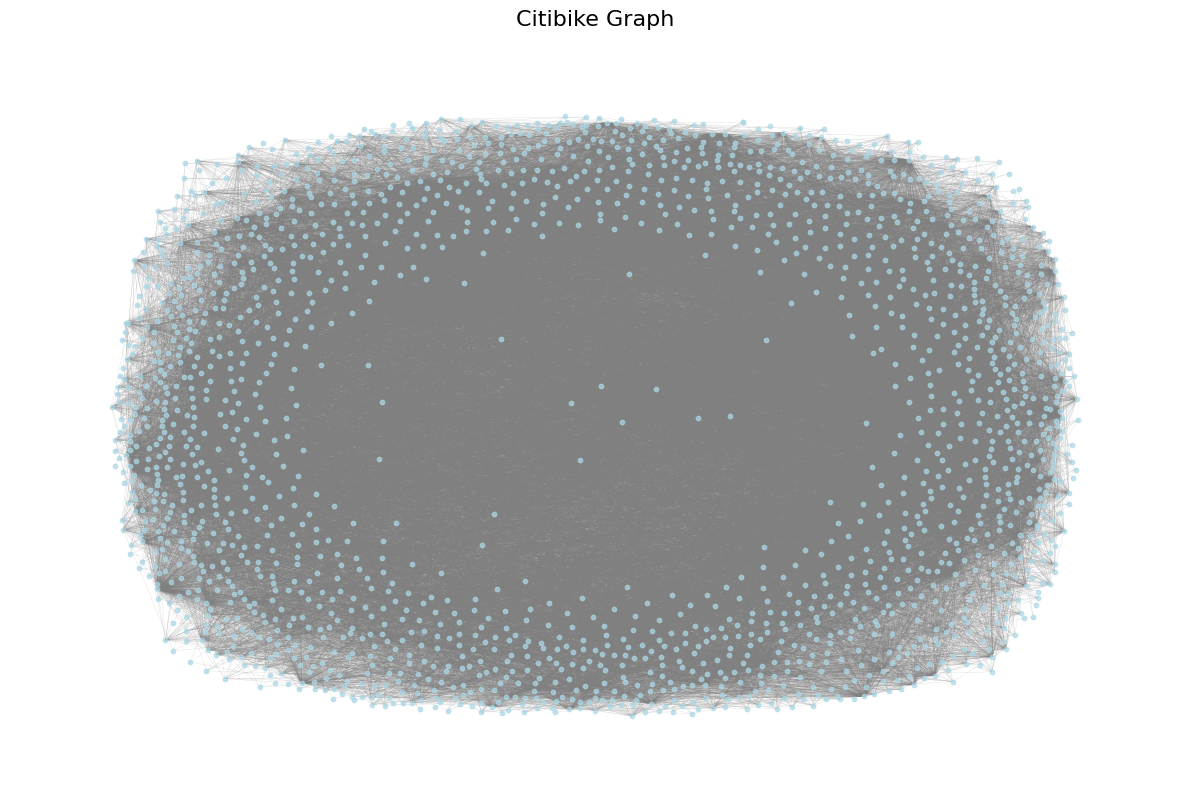

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))

layout = nx.spring_layout(G, k=1, iterations=10)

nx.draw(G, 
        pos=layout,
        with_labels=False,
        node_color='lightblue',     # Light blue nodes
        node_size=10,               # Larger nodes
        font_size=10,               # Adjust font size
        font_weight='bold',         # Bold labels
        edge_color='gray',          # Gray edges
        width=0.1,                  # Thicker edges
        alpha=0.7)                  # Some transparency

plt.title("Citibike Graph", fontsize=16, pad=20)

plt.tight_layout()

plt.show()

<h1>STEP 7: Answer the following questions for each of the graphs</h1>
<ol>Now we take a deep dive into the citibike trip network system. Please answer the following questions for df, classic_df and electric_df:
<li>Which stations (name) are the best (max degree) and worst connected (min degree)? (Show only first 5 or less)
<li>Travel between which pair of stations is the longest in terms of average duration between trip start and end. Report both the two stations as well as the time in minutes (float)
<li>Travel between which pair of stations is the longest in terms of average distance between trip start_station and end_station. Report both the two stations as well as the distance in kilometers (float).
<li>Which edges are associated with the most and least number of trips?
<li>Which station is "neareast" to all other stations (in terms of time)?
<li>Which station is "neareast" to all other stations (in terms of distance)?
<li>Which station is the most important connector or traffic bottleneck (in terms of trip count)?

**1a. Which stations (name) are the best connected (max degree)?  (Show only top)**

In [15]:
# Best connected stations for df:
sorted_list = sorted(G.degree(), key = lambda x:x[1], reverse = True)
best_connected = [nodes[node[0]] for node in sorted_list[:5]]
best_connected

['W 21 St & 6 Ave',
 '9 Ave & W 33 St',
 'Metropolitan Ave & Bedford Ave',
 'Leonard St & Nassau Ave',
 'W 22 St & 8 Ave']

In [16]:
# Best connected stations for classic_df:
sorted_list_classic = sorted(classic_G.degree(), key = lambda x:x[1], reverse = True)
best_connected_classic = [classic_nodes[node[0]] for node in sorted_list_classic[:5]]
best_connected_classic

['W 21 St & 6 Ave',
 '9 Ave & W 33 St',
 'W 22 St & 8 Ave',
 'W 49 St & 8 Ave',
 '12 Ave & W 40 St']

In [17]:
# Best connected stations for electric_df:
sorted_list_electric = sorted(electric_G.degree(), key = lambda x:x[1], reverse = True)
best_connected_electric = [electric_nodes[node[0]] for node in sorted_list_electric[:5]]
best_connected_electric

['W 21 St & 6 Ave',
 '9 Ave & W 33 St',
 'Metropolitan Ave & Bedford Ave',
 'Leonard St & Nassau Ave',
 'W 22 St & 8 Ave']

**1b. Which stations (name) are the worst connected (min degree)?  (Show only first 5 or less)**

In [18]:
# Worst connected stations for df:
sorted_list = sorted(G.degree(), key = lambda x:x[1], reverse = False)
worst_connected = [nodes[node[0]] for node in sorted_list[:5]]
worst_connected

['93 St & Roosevelt Ave',
 'Queens Blvd & Albion Ave',
 'St James Ave & 51 Ave',
 '51 Ave & Van Loon St',
 'Taylor St & Bedford Ave']

In [19]:
# Worst connected stations for classic_df:
sorted_list_classic = sorted(classic_G.degree(), key = lambda x:x[1], reverse = False)
worst_connected_classic = [classic_nodes[node[0]] for node in sorted_list_classic[:5]]
worst_connected_classic

['Prospect Ave & Vanderbilt St',
 'E 149 St & Jackson Ave',
 'Classon Ave & St Marks Ave',
 'Queens Blvd & Albion Ave',
 '10 St & 2 Ave']

In [20]:
# Worst connected stations for electric_df:
sorted_list_electric = sorted(electric_G.degree(), key = lambda x:x[1], reverse = False)
worst_connected_electric = [electric_nodes[node[0]] for node in sorted_list_electric[:5]]
worst_connected_electric

['93 St & Roosevelt Ave',
 'St James Ave & 51 Ave',
 '51 Ave & Van Loon St',
 'Hoe Ave & Jennings St',
 'Nostrand Ave & Myrtle Ave']

<br> **2. Show the pairs of stations with the longest trip in terms of average duration between trip start and end. Report both the two stations as well as the time in minutes (float)**

In [21]:
max_edge = max(G.edges(data=True), key=lambda edge: edge[2]['time'])
max_edge_classic = max(classic_G.edges(data=True), key=lambda edge: edge[2]['time'])
max_edge_electric = max(electric_G.edges(data=True), key=lambda edge: edge[2]['time'])

In [22]:
st1, st2, data = max_edge
st1_classic, st2_classic, data_classic = max_edge_classic
st1_electric, st2_electric, data_electric = max_edge_electric

In [23]:
# df
print("For df:\nStations: ", nodes[st1], "and", nodes[st2], "\nAverage Duration: ", float(data['time']))
# classic
print("For classic_df:\nStations: ", classic_nodes[st1_classic],"and",classic_nodes[st2_classic], "\nAverage Duration: ", float(data_classic['time']))
# electric
print("For electric_df:\nStations: ", electric_nodes[st1_electric], "and",electric_nodes[st2_electric], "\nAverage Duration: ", float(data_electric['time']))

For df:
Stations:  W 16 St & The High Line and Cadman Plaza E & Red Cross Pl 
Average Duration:  1277.49
For classic_df:
Stations:  W 16 St & The High Line and Cadman Plaza E & Red Cross Pl 
Average Duration:  1277.49
For electric_df:
Stations:  Freeman St & Southern Blvd and Beck St & Leggett Ave 
Average Duration:  563.18


<br> **3. Show the pairs of stations with the longest trip in terms of average distance between trip start_station and end_station. Report both the two stations as well as the distance in kilometers(float)**

In [24]:
max_edge = max(G.edges(data=True), key=lambda edge: edge[2]['distance'])
max_edge_classic = max(classic_G.edges(data=True), key=lambda edge: edge[2]['distance'])
max_edge_electric = max(electric_G.edges(data=True), key=lambda edge: edge[2]['distance'])

In [25]:
st1, st2, data = max_edge
st1_classic, st2_classic, data_classic = max_edge_classic
st1_electric, st2_electric, data_electric = max_edge_electric
# df
print("For df:\nStations: ", nodes[st1], "and", nodes[st2], "\nAverage Distance: ", float(data['distance']))
# classic
print("For classic_df:\nStations: ", classic_nodes[st1_classic],"and",classic_nodes[st2_classic], "\nAverage Distance: ", float(data_classic['distance']))
# electric
print("For electric_df:\nStations: ", electric_nodes[st1_electric], "and",electric_nodes[st2_electric], "\nAverage Distance: ", float(data_electric['distance']))

For df:
Stations:  Riverside Dr & Broadway and South St & Whitehall St 
Average Distance:  20.49
For classic_df:
Stations:  Lafayette St & E 8 St and Botanical Sq & Webster Ave 
Average Distance:  19.55
For electric_df:
Stations:  Riverside Dr & Broadway and South St & Whitehall St 
Average Distance:  20.49


**4. Which edges are associated with the most and least number of trips? (show all pairs)**

In [26]:
max_edge = max(G.edges(data=True), key=lambda edge: edge[2]['count'])
max_edge_classic = max(classic_G.edges(data=True), key=lambda edge: edge[2]['count'])
max_edge_electric = max(electric_G.edges(data=True), key=lambda edge: edge[2]['count'])

min_edge = min(G.edges(data=True), key=lambda edge: edge[2]['count'])
min_edge_classic = min(classic_G.edges(data=True), key=lambda edge: edge[2]['count'])
min_edge_electric = min(electric_G.edges(data=True), key=lambda edge: edge[2]['count'])

In [27]:
print("Most number of trips for df: ", max_edge)
print("Most number of trips for classic: ", max_edge_classic)
print("Most number of trips for electric: ", max_edge_electric)
print("Least number of trips for df: ", min_edge)
print("Least number of trips for classic: ", min_edge_classic)
print("Least number of trips for electric: ", min_edge_electric)


Most number of trips for df:  ('6492.08', '6726.01', {'count': 270, 'time': 5.895074074074075, 'distance': 0.89})
Most number of trips for classic:  ('6224.03', '6306.06', {'count': 164, 'time': 2.7481707317073165, 'distance': 0.64})
Most number of trips for electric:  ('6492.08', '6726.01', {'count': 228, 'time': 5.510219298245612, 'distance': 0.89})
Least number of trips for df:  ('8381.04', '8738.01', {'count': 1, 'time': 23.18, 'distance': 5.72})
Least number of trips for classic:  ('6304.04', '6651.01', {'count': 1, 'time': 9.3, 'distance': 1.11})
Least number of trips for electric:  ('8381.04', '8738.01', {'count': 1, 'time': 23.18, 'distance': 5.72})


**5. Which station is "neareast" to all other stations (in terms of distance=time)?**

In [28]:
from networkx.algorithms import closeness_centrality, betweenness_centrality

In [29]:
df_closeness = closeness_centrality(G, distance="time")
classic_df_closeness = closeness_centrality(classic_G,distance="time")
electric_df_closeness = closeness_centrality(electric_G, distance="time")

In [30]:
nearest = max(df_closeness.items(), key=lambda x: x[1])[0]
nearest_classic = max(classic_df_closeness.items(), key=lambda x: x[1])[0]
nearest_electric = max(electric_df_closeness.items(), key=lambda x: x[1])[0]
print("Station nearest to other stations for df:", nodes[nearest])
print("Station nearest to other stations for classic_df:",classic_nodes[nearest_classic])
print("Station nearest to other stations for electric_df:",electric_nodes[nearest_electric])

Station nearest to other stations for df: Davis St & Jackson Ave
Station nearest to other stations for classic_df: E 22 St & 2 Ave
Station nearest to other stations for electric_df: E 63 St & 3 Ave


**6. Which station is "neareast" to all other stations (in terms of distance=distance)?**

In [31]:
df_closeness_distance = closeness_centrality(G, distance="distance")
classic_df_closeness_distance = closeness_centrality(classic_G, distance="distance")
electric_df_closeness_distance = closeness_centrality(electric_G, distance="distance")

In [32]:
nearest_distance = max(df_closeness_distance.items(), key=lambda x: x[1])[0]
nearest_classic_distance = max(classic_df_closeness_distance.items(), key=lambda x: x[1])[0]
nearest_electric_distance = max(electric_df_closeness_distance.items(), key=lambda x: x[1])[0]
print("Station nearest to other stations (in terms of distance) for df:", nodes[nearest_distance])
print("Station nearest to other stations (in terms of distance) for classic_df:", classic_nodes[nearest_classic_distance])
print("Station nearest to other stations (in terms of distance) for electric_df:", electric_nodes[nearest_electric_distance])

Station nearest to other stations (in terms of distance) for df: Davis St & Jackson Ave
Station nearest to other stations (in terms of distance) for classic_df: Leonard St & Nassau Ave
Station nearest to other stations (in terms of distance) for electric_df: Davis St & Jackson Ave


**7. Which station is the most important connector or traffic bottleneck (in terms of trip count)?**

In [33]:
df_betweenness = betweenness_centrality(G, weight="count")
classic_df_betweenness = betweenness_centrality(classic_G, weight="count")
electric_df_betweenness = betweenness_centrality(electric_G, weight="count")

In [34]:
most_important_connector = max(df_betweenness.items(), key=lambda x: x[1])[0]
most_important_classic = max(classic_df_betweenness.items(), key=lambda x: x[1])[0]
most_important_electric = max(electric_df_betweenness.items(), key=lambda x: x[1])[0]
print("Most important connector (traffic bottleneck) for df:", nodes[most_important_connector])
print("Most important connector (traffic bottleneck) for classic_df:", classic_nodes[most_important_classic])
print("Most important connector (traffic bottleneck) for electric_df:", electric_nodes[most_important_electric])

Most important connector (traffic bottleneck) for df: Leonard St & Nassau Ave
Most important connector (traffic bottleneck) for classic_df: Leonard St & Nassau Ave
Most important connector (traffic bottleneck) for electric_df: Leonard St & Nassau Ave


<h2>Shortest path and shortest duration</h2>

**Find the shortest path and the shortest time duration between "Riverside Dr & Broadway" and "Botanical Sq & Webster Ave" in G.**

In [35]:
st1 = "Riverside Dr & Broadway"
st2 = "Botanical Sq & Webster Ave"
# accessing key using value learned from https://www.geeksforgeeks.org/python-get-key-from-value-in-dictionary/

st1_id = list(nodes.keys())[list(nodes.values()).index(st1)]
st2_id = list(nodes.keys())[list(nodes.values()).index(st2)]


In [36]:
shortest_path = nx.shortest_path(G, st1_id, st2_id, weight="time")
shortest_time = nx.shortest_path_length(G, st1_id, st2_id, weight="time")

print("Shortest path:", shortest_path)
print("Shortest time:", shortest_time)

Shortest path: ['8616.06', '8692.04', '8682.06', '8646.02']
Shortest time: 19.060000000000002


**Find the longest shortest path and its time duration in G**

In [37]:
nx.diameter(G)

6

In [38]:
nx.periphery(G)

['6304.04',
 '5501.06',
 '5887.03',
 '3208.07',
 '6390.05',
 '6056.02',
 '3620.02',
 '6701.05',
 '6014.01',
 '6047.03',
 '8095.06',
 '3782.03',
 '8277.03',
 '4357.01',
 '3742.11',
 '3448.02',
 '3090.06',
 '6028.01',
 '6825.03',
 '6005.04',
 '3246.06',
 '6287.02',
 '3327.01',
 '3019.03',
 '4904.03',
 '6502.01',
 '8828.02',
 '6727.02',
 '4945.06',
 '6323.04',
 '3463.01',
 '3408.05',
 '3113.10',
 '6062.03',
 '3000.08',
 '8451.07',
 '5471.04',
 '3140.09',
 '8579.09',
 '3312.07',
 '4807.02',
 '3608.06',
 '6692.03',
 '6433.01',
 '3233.02',
 '8876.04',
 '8835.05',
 '6216.01',
 '6465.04',
 '6070.05',
 '3704.04',
 '6509.07',
 '6405.03',
 '6724.01',
 '3822.08',
 '4778.03',
 '6451.07',
 '5074.08',
 '3728.04',
 '4689.08',
 '5217.03',
 '6748.04',
 '7719.13',
 '4154.02',
 '4483.10',
 '3982.01',
 '4137.10',
 '4553.04',
 '3286.07',
 '6490.02',
 '6457.06',
 '4560.01',
 '3180.02',
 '4119.04',
 '3710.07',
 '5010.02',
 '3831.03',
 '3135.04',
 '5090.06',
 '6108.03',
 '3768.02',
 '6660.05',
 '5225.02',
 '48

In [39]:
for n in nx.periphery(G):
    print(nodes[n])

98 St & 41 Ave
Fresh Pond Rd & Flushing Ave
Queens Blvd & 56 Ave
Dahill Rd & 12 Ave
93 St & Roosevelt Ave
Queens Blvd & Albion Ave
Windsor Pl & 8 Ave
Jackson Mill Rd & 93 St
St James Ave & 51 Ave
51 Ave & Van Loon St
Hoe Ave & Jennings St
Carroll St & Utica Ave
Washington Ave & E 174 St
Moffat St & Bushwick
Carroll St & Rochester Ave
Parkside Ave & Ocean Ave
Church Ave & McDonald Ave
57 Ave & 98 Pl
77 St & 24 Ave
55 Ave & 90 St
New York Ave & Snyder Ave
111 St & 49 Ave
Lott St & Erasmus St
Keegan Rd & 2 Ave
Cypress Hills St & Otto Rd
55 St & Northern Blvd
Sedgwick Ave & Hillman Ave
30 Ave & 70 St
Fresh Pond Rd & 69 Ave
84 St & Roosevelt Ave
Clarkson Ave & E 37 St
Ocean Ave & Crooke Ave
Stratford Rd & Beverley Rd
103 St & Martense Ave
6 Ave & 55 St
E 182 St & Park Ave
Grand Ave & 58 Ave
Bedford Ave & Beverley Rd
10 Ave & W 204 St
Prospect Ave & Greenwood Ave
Madison St & Cypress Ave
Maple St & Albany Ave
104 St & 32 Ave
92 St & 37 Ave
5 Ave & 44 St
Van Cortlandt Park S & Gouverneur Ave


In [40]:
len(nx.periphery(G))

191